In [22]:
import pandas as pd

# Read in data 
data = pd.read_csv('Resources/creditcard.csv')

# Unsupervised Outlier Detection

Now that we have processed our data, we can begin deploying our machine learning algorithms. We will use the following techniques:

## Local Outlier Factor (LOF)

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood.

In anomaly detection, the local outlier factor (LOF) is an algorithm proposed by Markus M. Breunig, Hans-Peter Kriegel, Raymond T. Ng and Jörg Sander in 2000 for finding anomalous data points by measuring the local deviation of a given data point with respect to its neighbours.

The local outlier factor is based on a concept of a local density, where locality is given by k {\displaystyle k} k nearest neighbors, whose distance is used to estimate the density. By comparing the local density of an object to the local densities of its neighbors, one can identify regions of similar density, and points that have a substantially lower density than their neighbors. These are considered to be outliers.

The local density is estimated by the typical distance at which a point can be "reached" from its neighbors. The definition of "reachability distance" used in LOF is an additional measure to produce more stable results within clusters. 

## Isolation Forest Algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [23]:
# Print the shape of the data
cc = data.sample(frac=0.1, random_state = 42)
print(cc.shape)
# print(cc.describe())

(28481, 31)


In [24]:
# Determine number of fraud cases in dataset

Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))

0.0017304750013189597
Fraud Cases: 492
Valid Transactions: 284315


In [25]:


# Get all the columns from the dataFrame
columns = cc.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]

# Store the variable we'll be predicting on
target = "Class"

X = cc[columns]
Y = cc[target]

# Print shapes
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


In [26]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# define random states
state = 42

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=30,
        contamination=outlier_fraction)}

In [27]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
# ignore all future warnings
simplefilter(action='ignore', category=DeprecationWarning)

In [28]:
# Fit the model
n_outliers = len(Fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(f"Accuracy Score: {accuracy_score(Y, y_pred)}")
    print(f"Classification Report:\n {classification_report(Y, y_pred)}")

Isolation Forest: 66
Accuracy Score: 0.9976826656367402
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28435
           1       0.30      0.33      0.31        46

   micro avg       1.00      1.00      1.00     28481
   macro avg       0.65      0.66      0.66     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 96
Accuracy Score: 0.9966293318352586
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28435
           1       0.00      0.00      0.00        46

   micro avg       1.00      1.00      1.00     28481
   macro avg       0.50      0.50      0.50     28481
weighted avg       1.00      1.00      1.00     28481



**Dimensionality Reduction**

T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton. It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. 

In [67]:
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

ccd = data

# features.head(5)
# cc = cc.head(2500)
cc1 = ccd.loc[ccd['Class'] == 1]
cc0 = ccd.loc[ccd['Class'] == 0]
cc0_reduced = cc0.sample(n=cc1.shape[0])
# print(cc1)
# print(cc1.shape)
# print(cc0.shape)
# print(cc0_reduced.shape)
# cc.head()
ccs = cc1.append(cc0_reduced, sort=False)
print(ccs.shape)


(984, 31)


In [68]:
from sklearn.manifold import TSNE
df2 = ccs
X = df2.drop('Class', axis=1)
y = df2['Class']


In [69]:
#t-SNE
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

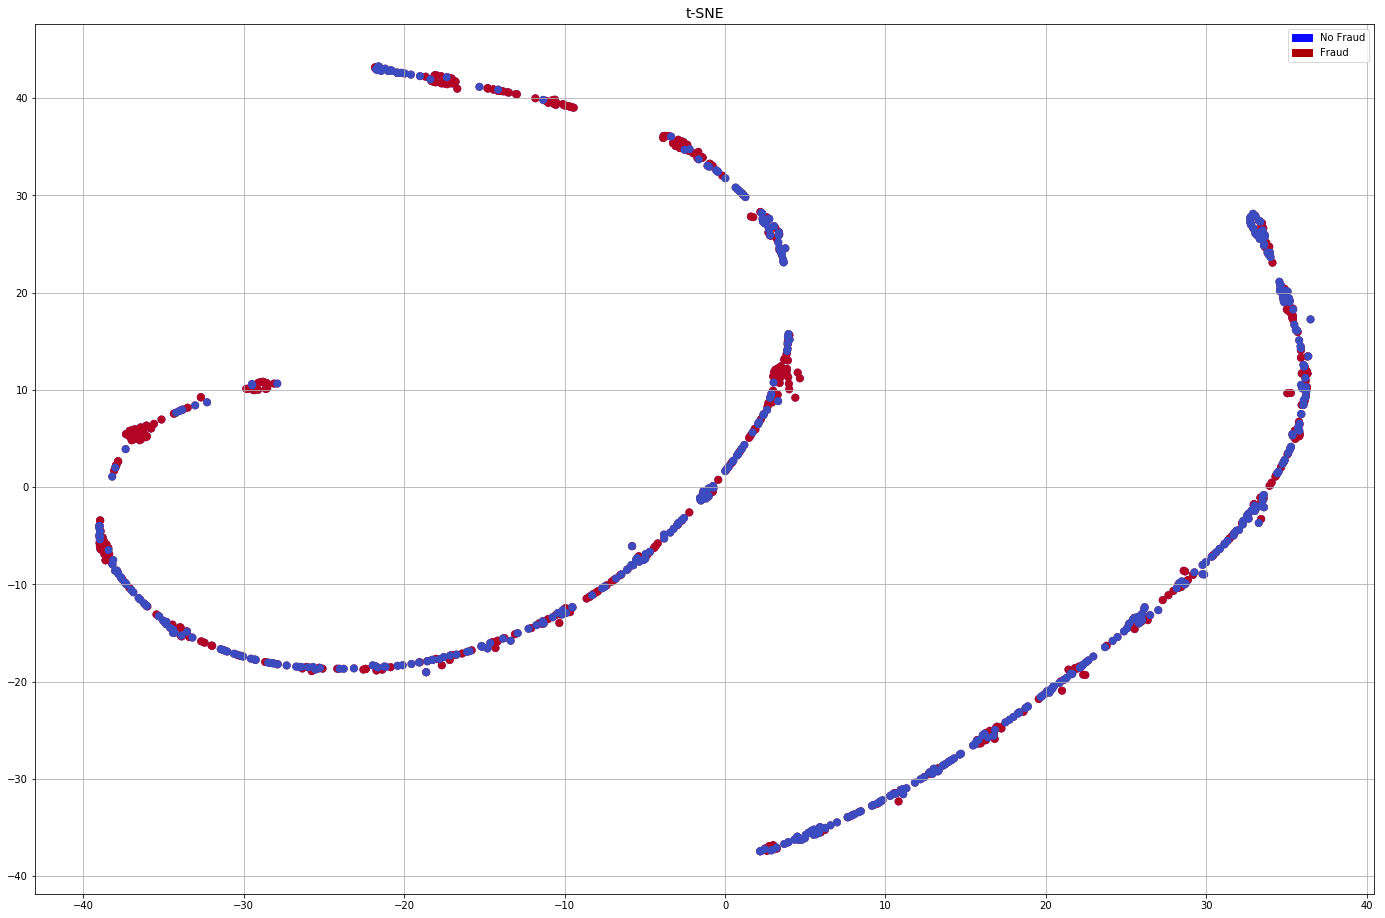

In [70]:
# t-SNE scatter plot
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(24,16))


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

**Classification Algorithms**

### LR:  Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist.
### LDA: Linear discriminant analysis is a method used in statistics, pattern recognition and machine learning to find a linear combination of features that characterizes or separates two or more classes of objects or events.
### KNN: The k-nearest neighbors algorithm (k-NN), in pattern recognition, is a non-parametric method used for classification and regression.In both cases, the input consists of the k closest training examples in the feature space. 
### CART: DecisionTreeClassifier is a decision tree classifier.
### SVM: C-Support Vector Classification. The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples.
### XGB: XGBClassifier XGBoost is an open-source software library which provides a gradient boosting framework.  It aims to provide a "Scalable, Portable and Distributed Gradient Boosting (GBM, GBRT, GBDT) Library". It has gained much popularity and attention recently as the algorithm of choice for many winning teams of machine learning competitions.
### RF:  RandomForestClassifier or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

#### To avoid overfitting, we used the very common resampling technique of k-fold cross-validation which is to separate the training data into k parts (folds) and then fit the model on k-1 folds before making predictions for the kth hold-out fold. Then repeating this process for every single fold and average the resulting predictions.

In [71]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [72]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
X_train = X_train.values
X_validation = X_test.values
y_train = y_train.values
y_validation = y_test.values

In [74]:
print('X_shapes:\n', 'X_train:', 'X_validation:\n', X_train.shape, X_validation.shape, '\n')
print('Y_shapes:\n', 'Y_train:', 'Y_validation:\n', y_train.shape, y_validation.shape)

X_shapes:
 X_train: X_validation:
 (787, 30) (197, 30) 

Y_shapes:
 Y_train: Y_validation:
 (787,) (197,)


In [75]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [76]:
##Spot-Checking Algorithms

models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier()))

#testing models

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.965241 (0.033545)
LDA: 0.960735 (0.023445)
KNN: 0.703763 (0.058160)
CART: 0.899259 (0.040818)
SVM: 0.627545 (0.016314)
XGB: 0.975005 (0.014978)
RF: 0.967345 (0.020627)


### As we can not going to rely on accuracy, we use of the Receiver Operating Characteristics-Area Under the Curve or ROC-AUC performance measure.
### The ROC-AUC outputs a value between zero and one, whereby one is a perfect score and zero the worst. If an algorithm has a ROC-AUC score of above 0.5, it is achieving a higher performance than random guessing.

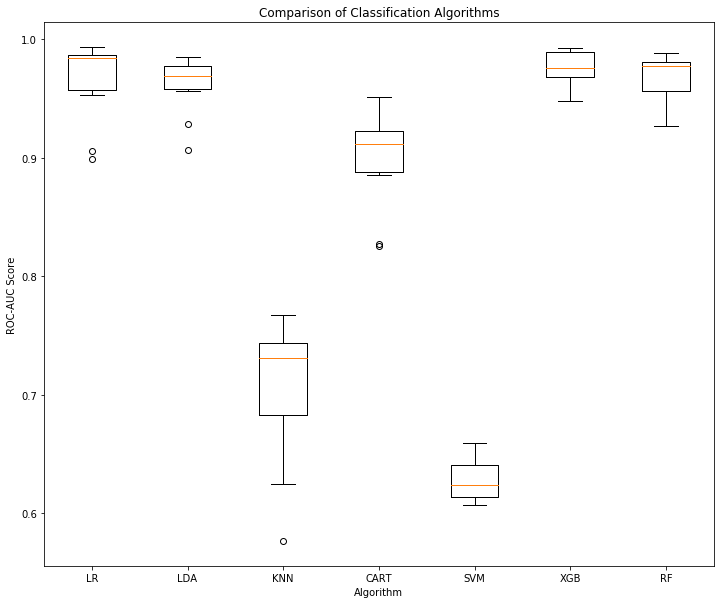

In [77]:
#Compare Algorithms

fig = plt.figure(figsize=(12,10))
plt.title('Comparison of Classification Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('ROC-AUC Score')
plt.boxplot(results)
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
plt.show()